In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.stats import describe
from tqdm import tqdm

from astropy.io import fits

from Py3D.core import image
from Py3D.functions import imageMethod

In [2]:
# define lab data path following SDSS nomenclature
# examples of dark frames (non-zero length exposure, closed shutter)
# examples of bias frames (zero length exposure, closed shutter)
# identify regions: pre-scan, over-scan, science
# remove non-science regions: pre-scan, overscan
# compute bias statistics:
#  - mean, median, standard deviation
#  - if there are several exposures, look for statistical variations between exposures
#  - compare over-scan bias and science bias
# compute dark statistics:
#  - mean, median, standard deviation
#  - if there are several exposures, look for statistical variations between exposures
# hints of CCDflat: look for common patterns in both set of images

In [3]:
# data root path
LVM_DEV = os.path.expandvars("$LVMHUB")
LVM_ROOT = os.path.join(LVM_DEV, "data.sdss5.org/sas/sdsswork/data/lvm")
LVM_DATA_LAB = os.path.join(LVM_ROOT, "lab")

In [4]:

frames_meta = pd.read_csv(os.path.join(LVM_DATA_LAB, "LVMI Exposure List - Sheet1.csv"))
frames_meta.filename = frames_meta.filename.str.strip()
frames_meta.set_index(["mjd","filename"], inplace=True)
frames_meta = frames_meta.drop_duplicates()

print(f"No. lab frames: {len(frames_meta)}")

No. lab frames: 1048


In [5]:
frame_paths = sorted([os.path.join(root,file) for root, _, files in os.walk(LVM_DATA_LAB) for file in files if (pd.to_numeric(os.path.basename(root),errors="ignore"),file) in frames_meta.index])
print(f"frames matched in lab data path: {len(frame_paths)}")

frames matched in lab data path: 86


In [6]:
new_index = list(map(lambda filepath: (int(os.path.basename(os.path.dirname(filepath))), os.path.basename(filepath)), frame_paths))

frames_meta_match = frames_meta.loc[new_index]
frames_meta_match["filepath"] = frame_paths
frames_meta_match

exp_no        date location test_no  \
mjd   filename                                                         
59364 sdR-s-r1-00000318.fits.gz     318  30/05/2021      SBS     NaN   
59365 sdR-s-r1-00000325.fits.gz     325  31/05/2021      SBS     NaN   
      sdR-s-r1-00000326.fits.gz     326  31/05/2021      SBS     NaN   
      sdR-s-r1-00000327.fits.gz     327  31/05/2021      SBS     NaN   
      sdR-s-r1-00000328.fits.gz     328  31/05/2021      SBS     NaN   
...                                 ...         ...      ...     ...   
59436 sdR-s-z1-00000412.fits.gz     412  10/08/2021      SBS     NaN   
      sdR-s-z1-00000413.fits.gz     413  10/08/2021      SBS     NaN   
      sdR-s-z1-00000414.fits.gz     414  10/08/2021      SBS     NaN   
      sdR-s-z1-00000415.fits.gz     415  10/08/2021      SBS     NaN   
59437 sdR-s-b1-00000437.fits.gz     437  11/08/2021      SBS     NaN   

                                test_iteration spec channel sources  \
mjd   filename                                                        
59364 sdR-s-r1-00000318.fits.gz            NaN  sp1      r1     NaN   
59365 sdR-s-r1-00000325.fits.gz            NaN  sp1      r1     NaN   
      sdR-s-r1-00000326.fits.gz            NaN  sp1      r1     NaN   
      sdR-s-r1-00000327.fits.gz            NaN  sp1      r1     NaN   
      sdR-s-r1-00000328.fits.gz            NaN  sp1      r1     NaN   
...                                        ...  ...     ...     ...   
59436 sdR-s-z1-00000412.fits.gz            NaN  sp1      z1     NaN   
      sdR-s-z1-00000413.fits.gz            NaN  sp1      z1     NaN   
      sdR-s-z1-00000414.fits.gz            NaN  sp1      z1     NaN   
      sdR-s-z1-00000415.fits.gz            NaN  sp1      z1     NaN   
59437 sdR-s-b1-00000437.fits.gz            NaN  sp1      b1     NaN   

                                lamp_current hartmanns  exptime  lab_temp  \
mjd   filename                                                              
59364 sdR-s-r1-00000318.fits.gz          NaN       NaN        0   22.3489   
59365 sdR-s-r1-00000325.fits.gz          NaN       NaN        0   22.4500   
      sdR-s-r1-00000326.fits.gz          NaN       NaN        0 -999.0000   
      sdR-s-r1-00000327.fits.gz          NaN       NaN        0 -999.0000   
      sdR-s-r1-00000328.fits.gz          NaN       NaN        0   22.4501   
...                                      ...       ...      ...       ...   
59436 sdR-s-z1-00000412.fits.gz          NaN       NaN        0   18.4619   
      sdR-s-z1-00000413.fits.gz          NaN       NaN        0   18.4622   
      sdR-s-z1-00000414.fits.gz          NaN       NaN        0   18.4621   
      sdR-s-z1-00000415.fits.gz          NaN       NaN        0   18.4621   
59437 sdR-s-b1-00000437.fits.gz          NaN         ?        0   20.6000   

                                  ccd_temp purpose          notes  \
mjd   filename                                                      
59364 sdR-s-r1-00000318.fits.gz  25.809980     NaN  Software test   
59365 sdR-s-r1-00000325.fits.gz  25.578768     NaN  Software test   
      sdR-s-r1-00000326.fits.gz  25.630374     NaN  Software test   
      sdR-s-r1-00000327.fits.gz  25.665460     NaN  Software test   
      sdR-s-r1-00000328.fits.gz  25.618968     NaN  Software test   
...                                    ...     ...            ...   
59436 sdR-s-z1-00000412.fits.gz  23.920928     NaN            NaN   
      sdR-s-z1-00000413.fits.gz  23.923836     NaN            NaN   
      sdR-s-z1-00000414.fits.gz  23.932800     NaN            NaN   
      sdR-s-z1-00000415.fits.gz  23.936652     NaN            NaN   
59437 sdR-s-b1-00000437.fits.gz  23.276142     NaN            NaN   

                                                                          filepath  
mjd   filename                                                                      
59364 sdR-s-r1-00000318.fits.gz  /disk-a/mejia/Research/UNAM/lvm-drp/data.sdss5...  
59365 sdR-s-r1-00

In [7]:
iframe = 0

frame = fits.open(frames_meta_match.filepath.values[iframe])

ny, nx = frame[0].data.shape
data = frame[0].data

frame[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4120                                                  
NAXIS2  =                 4080                                                  
SPEC    = 'sp1     '                                                            
OBSERVAT= 'LCO     '                                                            
OBSTIME = '2021-05-30T09:04:54.198' / Start of the observation                  
EXPTIME =                  0.0                                                  
IMAGETYP= 'bias    '                                                            
INTSTART= '2021-05-30T09:04:54.198' / Start of the integration                  
INTEND  = '2021-05-30T09:05:00.388' / End of the integration                    
CCD     = 'r1      '        

<BarContainer object of 4080 artists>

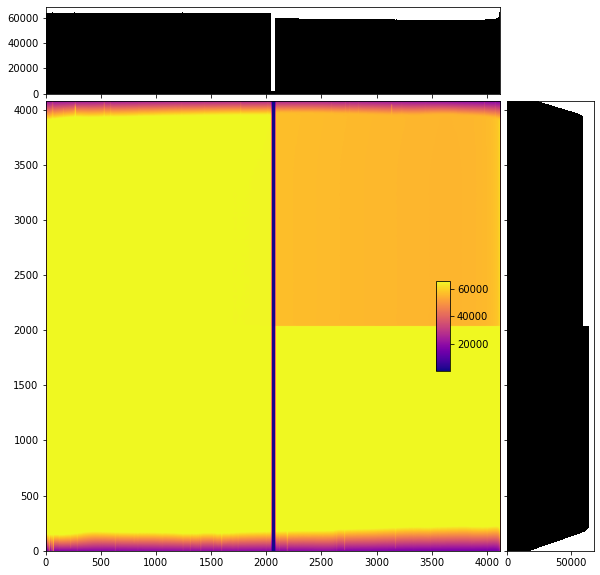

In [27]:
fig, ax = plt.subplots(figsize=(10,10))

im = ax.imshow(data, origin="lower", cmap="plasma")
ax.set_aspect(1.)

divider = make_axes_locatable(ax)

ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)
ax_color = inset_axes(
    ax,
    width="3%",
    height="20%",
    loc='center right',
    borderpad=5
)

ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)
# ax_histx.set_yscale("log")
# ax_histy.set_xscale("log")

cb = plt.colorbar(im, cax=ax_color)

ax_histx.bar(np.arange(nx), height=data.mean(axis=0), width=1, lw=0, align="center", color="k")
ax_histy.barh(np.arange(ny), width=data.mean(axis=1), height=1, lw=0, align="center", color="k")

final shape for amplifier region a: (2040, 2040)
final shape for amplifier region b: (2040, 2040)
final shape for amplifier region c: (2040, 2040)
final shape for amplifier region d: (2040, 2040)
{'a': 1779.0, 'b': 1746.0, 'c': 2013.0, 'd': 1822.0}
{'a': 65535.0, 'b': 55621.0, 'c': 65535.0, 'd': 65535.0}


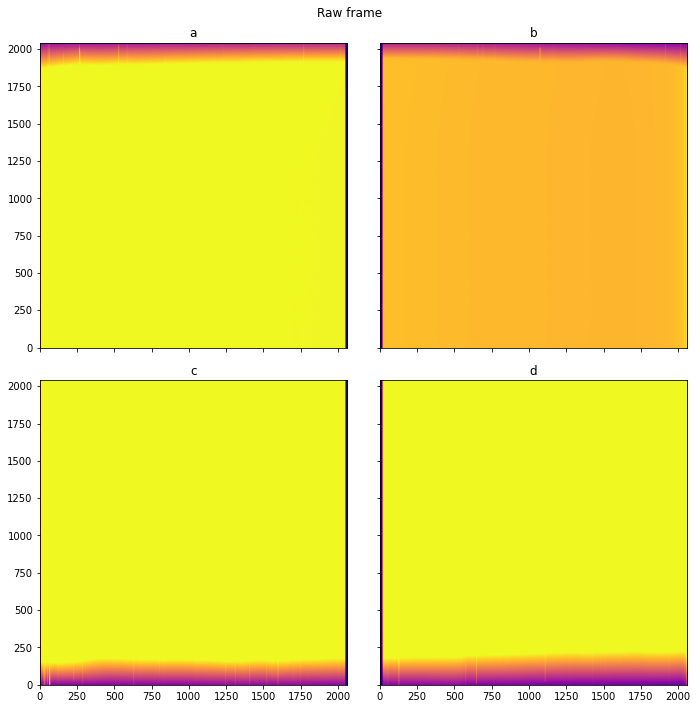

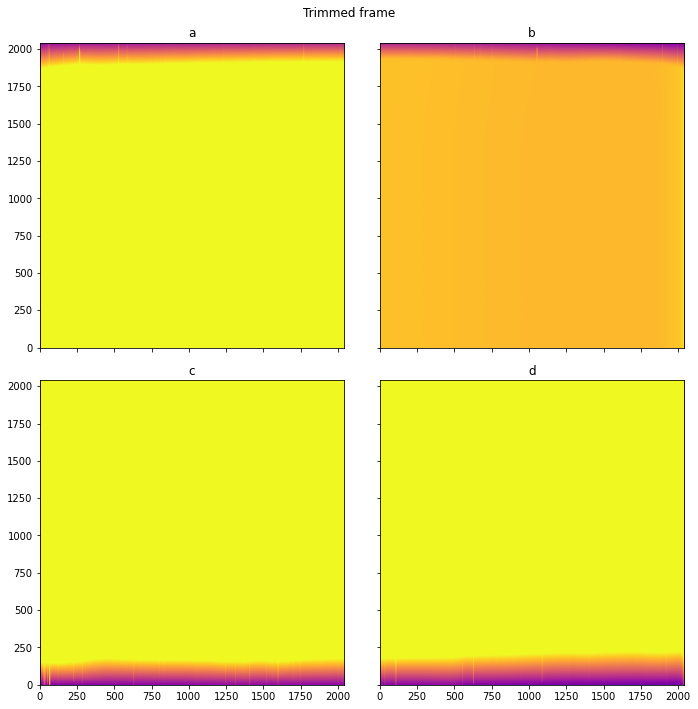

In [30]:
AMPLIFIER_WIDTH, AMPLIFIER_HEIGHT = nx//2, ny//2
OVERSCAN_WIDTH = 20
PRESCAN_WIDTH = 4
AMPLIFIER_NAMES = list("abcd")

fig_raw, axs_raw = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
axs_raw = axs_raw.ravel()

fig_cut, axs_cut = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
axs_cut = axs_cut.ravel()

amplifiers = dict.fromkeys(AMPLIFIER_NAMES)
amplifiers["a"] = image.Image(data=data[AMPLIFIER_HEIGHT:,:AMPLIFIER_WIDTH])
amplifiers["b"] = image.Image(data=data[AMPLIFIER_HEIGHT:,AMPLIFIER_WIDTH:])
amplifiers["c"] = image.Image(data=data[:AMPLIFIER_HEIGHT,:AMPLIFIER_WIDTH])
amplifiers["d"] = image.Image(data=data[:AMPLIFIER_HEIGHT,AMPLIFIER_WIDTH:])

os_bias = dict.fromkeys(AMPLIFIER_NAMES)
fr_bias = dict.fromkeys(AMPLIFIER_NAMES)
for i, amp in enumerate(AMPLIFIER_NAMES):
    axs_raw[i].imshow(amplifiers[amp]._data, origin="lower", cmap="plasma")
    axs_raw[i].set_title(amp)
    if amp in "ac":
        os_bias[amp] = amplifiers[amp].cutOverscan(bound_x=(1,AMPLIFIER_HEIGHT), bound_y=(1,AMPLIFIER_WIDTH-OVERSCAN_WIDTH), subtract=False)
    if amp in "bd":
        os_bias[amp] = amplifiers[amp].cutOverscan(bound_x=(1+OVERSCAN_WIDTH,AMPLIFIER_WIDTH), bound_y=(1,AMPLIFIER_HEIGHT), subtract=False)
    fr_bias[amp] = np.median(amplifiers[amp]._data)

    axs_cut[i].imshow(amplifiers[amp]._data, origin="lower", cmap="plasma", vmin=1500, vmax=65000)
    axs_cut[i].set_title(amp)
    
    print(f"final shape for amplifier region {amp}: {amplifiers[amp]._dim}")

fig_raw.suptitle("Raw frame")
fig_raw.tight_layout()
fig_cut.suptitle("Trimmed frame")
fig_cut.tight_layout()

print(os_bias)
print(fr_bias)

In [104]:
AXES_NAMES = "xy"
STATS_FIELDS = (
    "os_bias fr_bias".split() +
    [f"{stat}_{ax}" for ax in AXES_NAMES for stat in "min max median mean std skew kurt".split()]
)
STATS_FIELDS = [f"{field}_{amp}" for amp in AMPLIFIER_NAMES for field in STATS_FIELDS]

frames_stats = dict.fromkeys(frames_meta_match.index)
for iframe, idx in tqdm(enumerate(frames_meta_match.index), total=len(frames_meta_match), desc="computing frames stats", unit="frame", ascii=True):
    header = fits.getheader(frames_meta_match.filepath.values[iframe])
    data = fits.getdata(frames_meta_match.filepath.values[iframe])

    row = dict.fromkeys(STATS_FIELDS, np.nan)
    if data.size == 0:
        frames_stats[idx] = row
        continue

    amplifiers = dict.fromkeys(AMPLIFIER_NAMES)
    amplifiers["a"] = image.Image(data=data[AMPLIFIER_HEIGHT:,:AMPLIFIER_WIDTH])
    amplifiers["b"] = image.Image(data=data[AMPLIFIER_HEIGHT:,AMPLIFIER_WIDTH:])
    amplifiers["c"] = image.Image(data=data[:AMPLIFIER_HEIGHT,:AMPLIFIER_WIDTH])
    amplifiers["d"] = image.Image(data=data[:AMPLIFIER_HEIGHT,AMPLIFIER_WIDTH:])

    for i, amp in enumerate(AMPLIFIER_NAMES):
        if amp in "ac":
            row[f"os_bias_{amp}"] = amplifiers[amp].cutOverscan(bound_x=(1,AMPLIFIER_HEIGHT), bound_y=(1,AMPLIFIER_WIDTH-OVERSCAN_WIDTH), subtract=False)
        if amp in "bd":
            row[f"os_bias_{amp}"] = amplifiers[amp].cutOverscan(bound_x=(1+OVERSCAN_WIDTH,AMPLIFIER_WIDTH), bound_y=(1,AMPLIFIER_HEIGHT), subtract=False)
        
        row[f"fr_bias_{amp}"] = np.median(amplifiers[amp]._data)
        for iax, ax in enumerate(AXES_NAMES):
            _, (_min, _max), mean, var, skew, kurt = describe(amplifiers[amp]._data.mean(axis=iax))
            median = np.median(amplifiers[amp]._data.mean(axis=iax))
            
            row[f"median_{ax}_{amp}"] = median
            row[f"min_{ax}_{amp}"] = _min
            row[f"max_{ax}_{amp}"] = _max
            row[f"mean_{ax}_{amp}"] = mean
            row[f"std_{ax}_{amp}"] = np.sqrt(var)
            row[f"skew_{ax}_{amp}"] = skew
            row[f"kurt_{ax}_{amp}"] = kurt
    
    frames_stats[idx] = row

computing frames stats: 100%|##########| 86/86 [01:16<00:00,  1.12frame/s]


In [107]:
# filter by:
#  - exptime (0, 1)
#  - channel (r1, b1, z1)
#  - spec (eventually)

stats = pd.DataFrame.from_dict(frames_stats, orient="index")
stats.describe().T

,count,mean,std,min,25%,50%,75%,max
os_bias_a,74.0,1456.202703,273.900041,999.000000,1255.000000,1562.500000,1640.000000,1905.000000
fr_bias_a,74.0,45793.972973,23464.364880,999.000000,22583.000000,65535.000000,65535.000000,65535.000000
min_x_a,74.0,1481.778378,285.405244,999.445098,1264.141667,1601.425980,1682.057108,1931.088725
max_x_a,74.0,49132.897079,21852.376204,999.553431,25799.207721,64251.001961,64411.223162,65535.000000
median_x_a,74.0,41676.700977,20832.234551,999.499510,19212.762316,55652.610172,58001.700123,64133.389951
...,...,...,...,...,...,...,...,...
median_y_d,74.0,46477.403001,22311.159547,999.291667,22047.820956,63253.649510,63599.351225,65446.753186
mean_y_d,74.0,42598.682673,20218.532119,999.311581,21269.647116,55736.890071,56654.956572,65446.750632
std_y_d,74.0,7729.956512,7059.191311,0.017367,69.603981,5936.792839,14802.945409,17942.927507
skew_y_d,74.0,-10.177947,18.413368,-44.975165,-2.264288,-1.972641,-1.345751,23.802469


In [108]:
bias_mask = frames_meta_match.exptime==0
dark_mask = frames_meta_match.exptime>0

bias_full = stats.loc[bias_mask]
bias_full["channel"] = frames_meta_match.loc[:,"channel"]

dark_full = stats.loc[dark_mask]

bias_desc = bias_full.describe()
dark_desc = dark_full.describe()

         median_x_a    median_y_a    median_x_b    median_y_b    median_x_c    median_y_c    median_x_d    median_y_d
count     66.000000     66.000000     66.000000     66.000000     66.000000     66.000000     66.000000     66.000000
mean   45464.600045  50143.394437  45348.392123  50179.991477  45011.336976  50389.710970  45548.009793  49854.563187
std    18286.233879  20479.542006  17930.490056  20118.066183  18153.742681  20321.812730  17838.503905  19704.168425
min    18369.831127  19457.860784  18345.887500  18862.110049  17705.548284  18258.583824  17319.131373  17791.428186
25%    22111.969975  22943.031311  23961.067770  24473.099816  23068.432966  23269.933333  23828.055515  24060.848897
50%    57110.290196  65415.890564  55828.307108  65441.031985  56522.521569  65441.167402  56375.685784  63299.629534
75%    58013.293627  65441.350000  57792.997120  65441.420098  57469.504167  65441.262745  57131.390319  63620.766667
max    64133.389951  65503.681373  64988.078676  65442.8

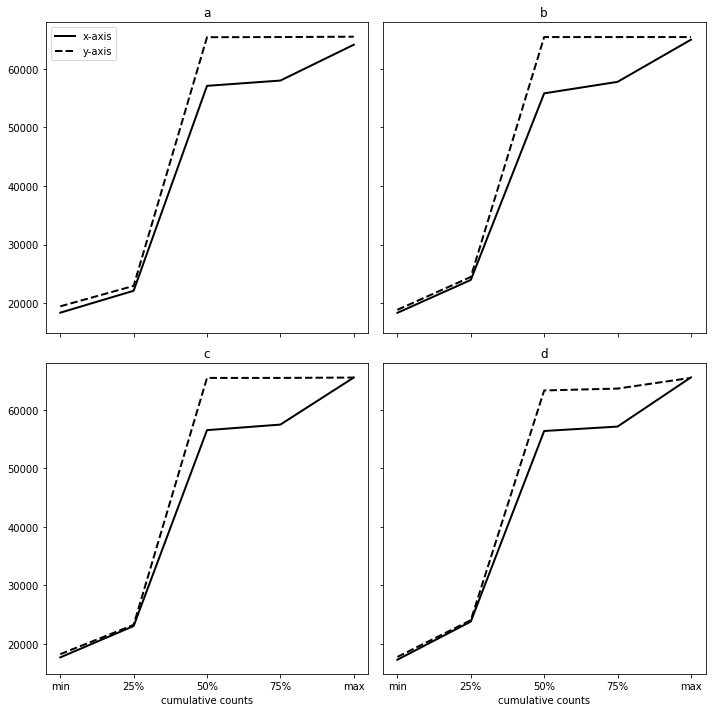

In [239]:
st_name = "median"
percentiles = "min 25% 50% 75% max".split()

fig, axs = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
axs = axs.ravel()

stat_df = bias_desc.filter(like=f"{st_name}")
print(stat_df.to_string())
for i, amp in enumerate(AMPLIFIER_NAMES):
    axs[i].plot(percentiles, stat_df.loc[percentiles,f"{st_name}_x_{amp}"], "-", color="k", lw=2, label="x-axis")
    axs[i].plot(percentiles, stat_df.loc[percentiles,f"{st_name}_y_{amp}"], "--", color="k", lw=2, label="y-axis")
    axs[i].set_title(amp)

axs[0].legend(loc=2)
axs[-2].set_xlabel(f"cumulative counts")
axs[-1].set_xlabel(f"cumulative counts")
fig.tight_layout()

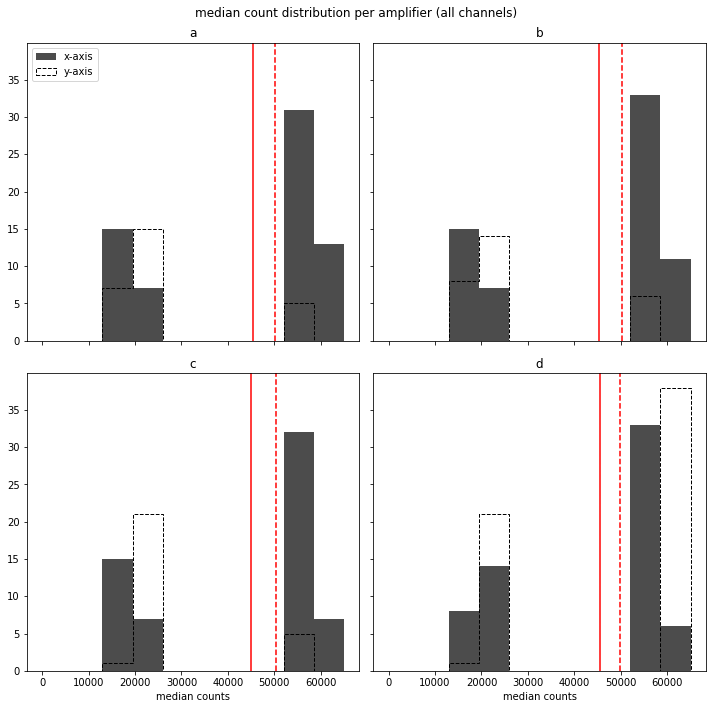

In [214]:
fig, axs = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
axs = axs.ravel()

st_name = "median"
stat_df = bias_full.copy()
for i, amp in enumerate(AMPLIFIER_NAMES):
    axs[i].hist(stat_df.loc[:,f"{st_name}_x_{amp}"], range=(0,65000), bins=10, color="k", alpha=0.7, histtype="stepfilled", label="x-axis")
    axs[i].hist(stat_df.loc[:,f"{st_name}_y_{amp}"], range=(0,65000), bins=10, color="k", alpha=1.0, histtype="step", ls="--", label="y-axis")
    axs[i].axvline(stat_df.loc[:,f"{st_name}_x_{amp}"].mean(), ls="-", color="r")
    axs[i].axvline(stat_df.loc[:,f"{st_name}_y_{amp}"].mean(), ls="--", color="r")
    axs[i].set_title(amp)

axs[0].legend(loc=2)
axs[-2].set_xlabel(f"{st_name} counts")
axs[-1].set_xlabel(f"{st_name} counts")
fig.suptitle(f"{st_name} count distribution per amplifier (all channels)")
fig.tight_layout()

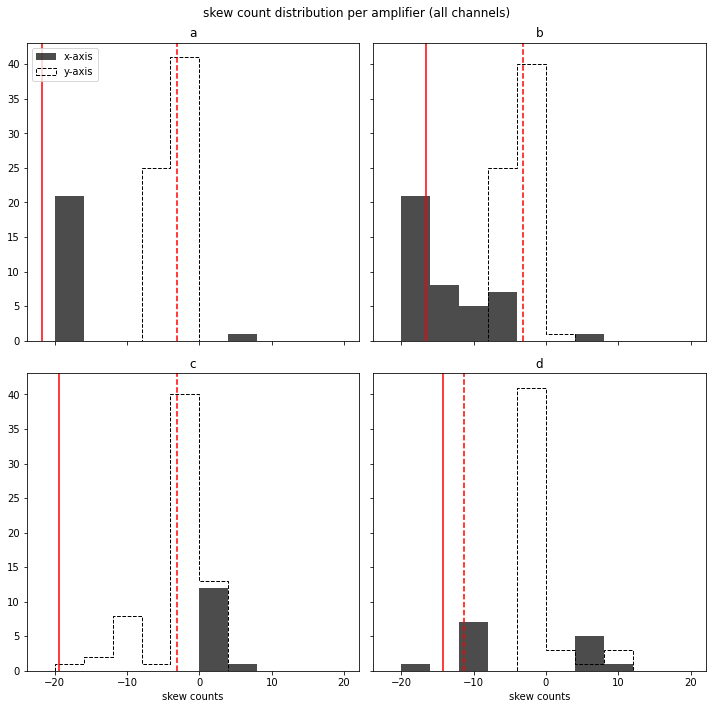

In [220]:
fig, axs = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
axs = axs.ravel()

st_name = "skew"
stat_df = bias_full.copy()
for i, amp in enumerate(AMPLIFIER_NAMES):
    axs[i].hist(stat_df.loc[:,f"{st_name}_x_{amp}"], range=(-20,20), bins=10, color="k", alpha=0.7, histtype="stepfilled", label="x-axis")
    axs[i].hist(stat_df.loc[:,f"{st_name}_y_{amp}"], range=(-20,20), bins=10, color="k", alpha=1.0, histtype="step", ls="--", label="y-axis")
    axs[i].axvline(stat_df.loc[:,f"{st_name}_x_{amp}"].mean(), ls="-", color="r")
    axs[i].axvline(stat_df.loc[:,f"{st_name}_y_{amp}"].mean(), ls="--", color="r")
    axs[i].set_title(amp)

axs[0].legend(loc=2)
axs[-2].set_xlabel(f"{st_name} counts")
axs[-1].set_xlabel(f"{st_name} counts")
fig.suptitle(f"{st_name} count distribution per amplifier (all channels)")
fig.tight_layout()

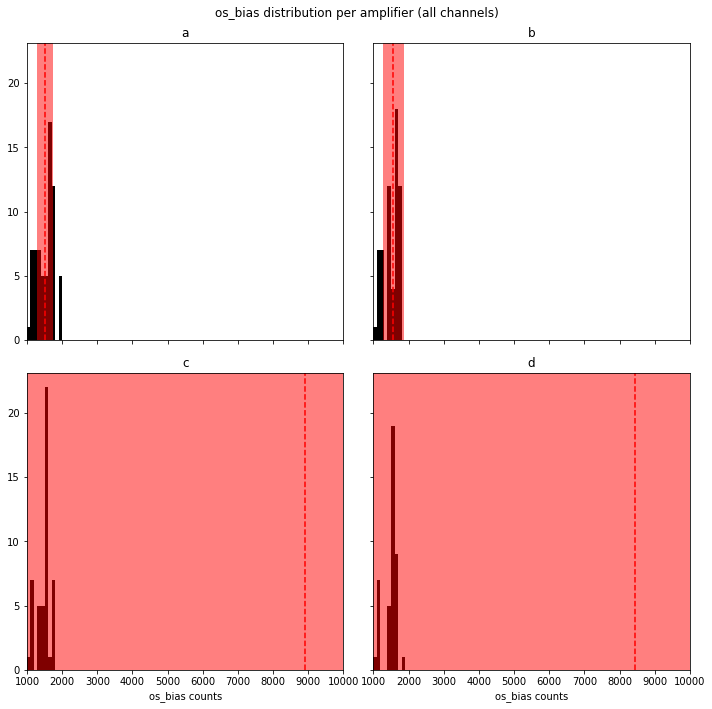

In [226]:
fig, axs = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
axs = axs.ravel()

st_name = "os_bias"
stat_df = bias_full.filter(like=st_name)
for i, amp in enumerate(AMPLIFIER_NAMES):
    axs[i].hist(stat_df.loc[:,f"{st_name}_{amp}"], range=(1000,2000), bins=10, color="k")
    mean, std = stat_df.loc[:,f"{st_name}_{amp}"].mean(), stat_df.loc[:,f"{st_name}_{amp}"].std()
    axs[i].axvspan(mean-std, mean+std, lw=0, fc="r", alpha=0.5)
    axs[i].axvline(mean, ls="--", color="r")
    axs[i].set_title(amp)

axs[-2].set_xlabel(f"{st_name} counts")
axs[-1].set_xlabel(f"{st_name} counts")
fig.suptitle(f"{st_name} distribution per amplifier (all channels)")
plt.xlim(1000,10000)
fig.tight_layout()

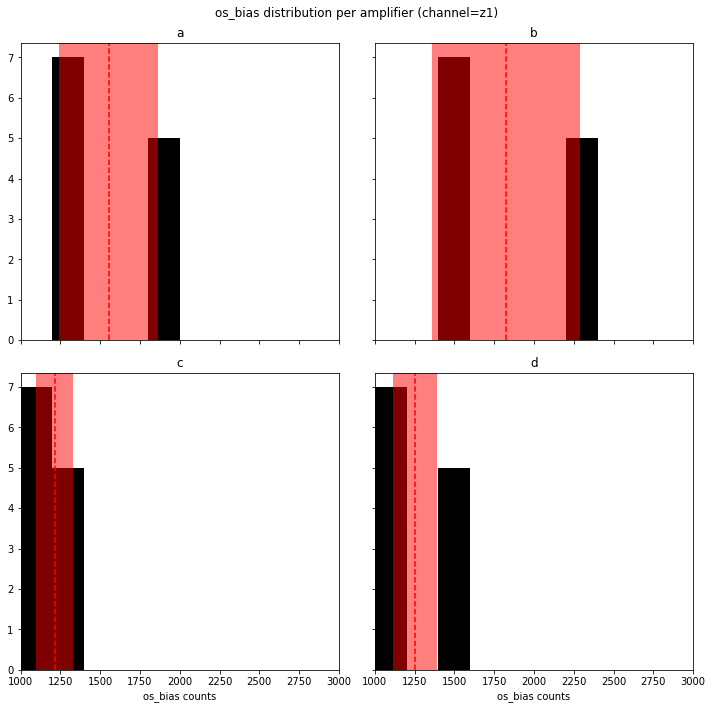

In [227]:
fig, axs = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
axs = axs.ravel()

channel = "z1"
st_name = "os_bias"
stat_df = bias_full.loc[bias_full.channel==channel].filter(like=st_name)
for i, amp in enumerate(AMPLIFIER_NAMES):
    axs[i].hist(stat_df.loc[:,f"{st_name}_{amp}"], range=(1000,3000), bins=10, color="k")
    mean, std = stat_df.loc[:,f"{st_name}_{amp}"].mean(), stat_df.loc[:,f"{st_name}_{amp}"].std()
    axs[i].axvspan(mean-std, mean+std, lw=0, fc="r", alpha=0.5)
    axs[i].axvline(mean, ls="--", color="r")
    axs[i].set_title(amp)

axs[-2].set_xlabel(f"{st_name} counts")
axs[-1].set_xlabel(f"{st_name} counts")
fig.suptitle(f"{st_name} distribution per amplifier (channel={channel})")
plt.xlim(1000,3000)
fig.tight_layout()

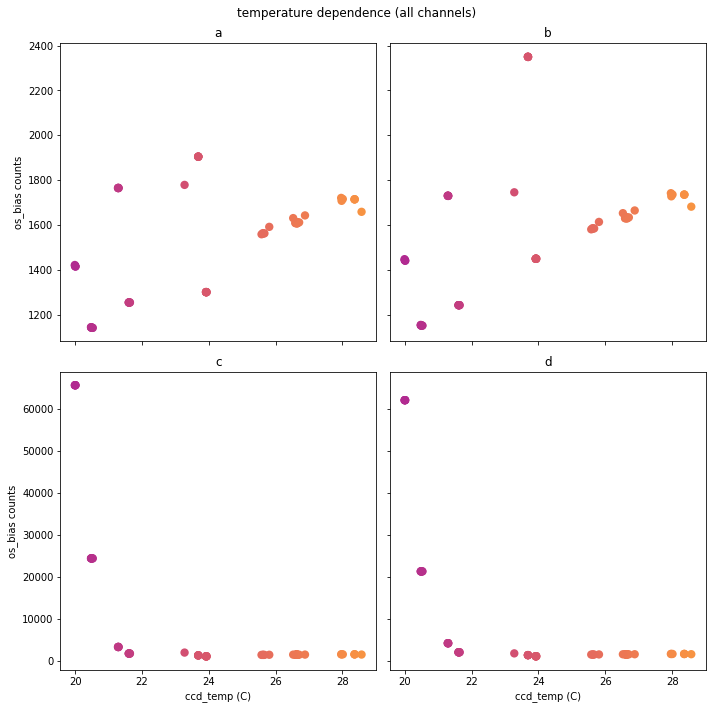

In [237]:
fig, axs = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey="row")
axs = axs.ravel()

st_name = "os_bias"
x_name = "ccd_temp"
z_name = "lab_temp"
stat_df = pd.concat((bias_full,frames_meta_match.filter(["lab_temp", "ccd_temp"])), axis="columns")
stat_df = stat_df.mask(stat_df==-999.0000).mask(stat_df.ccd_temp<0)
for i, amp in enumerate(AMPLIFIER_NAMES):
    axs[i].scatter(stat_df.loc[:,x_name], stat_df.loc[:,f"{st_name}_{amp}"], c=stat_df.loc[:,x_name], s=70, lw=0, cmap="plasma", vmin=10, vmax=35)
    axs[i].set_title(amp)

axs[-2].set_xlabel(f"{x_name} (C)")
axs[-1].set_xlabel(f"{x_name} (C)")
axs[0].set_ylabel(f"{st_name} counts")
axs[-2].set_ylabel(f"{st_name} counts")
fig.suptitle("temperature dependence (all channels)")
fig.tight_layout()